<a href="https://colab.research.google.com/github/aboood010/KRR-Assign2/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies
!pip install torch torchvision tqdm

In [2]:
# Import required libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Define transformations for Self-Supervised Learning (SimCLR augmentations)
transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Import ResNet
from torchvision.models import resnet18

class SimCLR(nn.Module):
    def __init__(self, base_model, projection_dim=128):
        super(SimCLR, self).__init__()
        self.encoder = base_model
        self.encoder.fc = nn.Identity()  # Remove classification layer
        self.projection_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)  # Extract features
        z = self.projection_head(h)  # Project to lower-dimensional space
        return h, z

# Instantiate the model
base_model = resnet18(pretrained=False)
model = SimCLR(base_model).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        z = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)

        labels = torch.cat([torch.arange(batch_size) for _ in range(2)], dim=0).to(device)
        loss = F.cross_entropy(similarity_matrix / self.temperature, labels)
        return loss


In [6]:
def train_ssl(model, dataloader, epochs=10):
    # Define optimizer here
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Example optimizer
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, _ in tqdm(dataloader):
            images = images.to(device)

            # Convert tensor images to PIL and apply augmentation
            images_1 = torch.stack([transform(transforms.ToPILImage()(img)) for img in images])
            images_2 = torch.stack([transform(transforms.ToPILImage()(img)) for img in images])

            images_1, images_2 = images_1.to(device), images_2.to(device)
            _, z_i = model(images_1)
            _, z_j = model(images_2)

            # Instantiate NTXentLoss here
            nt_xent_loss = NTXentLoss()

            loss = nt_xent_loss(z_i, z_j)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")

# Call train_ssl with only model and train_loader
train_ssl(model, train_loader, epochs=10)

100%|██████████| 391/391 [03:09<00:00,  2.07it/s]


Epoch 1, Loss: 4.2259832056587


100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch 2, Loss: 4.118093094252564


100%|██████████| 391/391 [02:47<00:00,  2.34it/s]


Epoch 3, Loss: 4.074814622054625


100%|██████████| 391/391 [02:47<00:00,  2.34it/s]


Epoch 4, Loss: 4.052235491135541


100%|██████████| 391/391 [02:45<00:00,  2.36it/s]


Epoch 5, Loss: 4.033344571852623


100%|██████████| 391/391 [02:45<00:00,  2.36it/s]


Epoch 6, Loss: 4.023437768297122


100%|██████████| 391/391 [02:45<00:00,  2.36it/s]


Epoch 7, Loss: 4.010627438650107


100%|██████████| 391/391 [02:46<00:00,  2.35it/s]


Epoch 8, Loss: 4.003204567048251


100%|██████████| 391/391 [02:46<00:00,  2.35it/s]


Epoch 9, Loss: 3.995165170001252


100%|██████████| 391/391 [02:46<00:00,  2.34it/s]

Epoch 10, Loss: 3.9881159015323804


In [7]:
torch.save(model.state_dict(), "simclr_cifar10.pth")
print("Model saved successfully!")

Model saved successfully!


In [8]:
class LinearClassifier(nn.Module):
    def __init__(self, backbone, num_classes=10):
        super(LinearClassifier, self).__init__()
        self.encoder = backbone
        self.encoder.fc = nn.Identity()  # Remove projection head
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)
        return self.classifier(features)

# Load pre-trained SSL model and freeze encoder
model.load_state_dict(torch.load("simclr_cifar10.pth"))
classifier = LinearClassifier(model.encoder).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


<ipython-input-8-abd79bffabc7>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("simclr_cifar10.pth"))


In [9]:
def train_classifier(model, dataloader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}, Accuracy: {100.0 * correct / total:.2f}%")

train_classifier(classifier, train_loader, optimizer, epochs=10)

100%|██████████| 391/391 [00:39<00:00,  9.82it/s]


Epoch 1, Loss: 1.9060190245318596, Accuracy: 29.06%


100%|██████████| 391/391 [00:39<00:00,  9.78it/s]


Epoch 2, Loss: 1.860744220521444, Accuracy: 30.83%


100%|██████████| 391/391 [00:39<00:00,  9.84it/s]


Epoch 3, Loss: 1.8555960078983356, Accuracy: 31.22%


100%|██████████| 391/391 [00:40<00:00,  9.71it/s]


Epoch 4, Loss: 1.850203067445389, Accuracy: 31.51%


100%|██████████| 391/391 [00:40<00:00,  9.74it/s]


Epoch 5, Loss: 1.8412464732099372, Accuracy: 31.84%


100%|██████████| 391/391 [00:39<00:00,  9.81it/s]


Epoch 6, Loss: 1.8381719845335196, Accuracy: 31.90%


100%|██████████| 391/391 [00:39<00:00,  9.85it/s]


Epoch 7, Loss: 1.8387511697266719, Accuracy: 32.07%


100%|██████████| 391/391 [00:39<00:00,  9.82it/s]


Epoch 8, Loss: 1.8322170177079222, Accuracy: 32.05%


100%|██████████| 391/391 [00:39<00:00,  9.82it/s]


Epoch 9, Loss: 1.8283404282596716, Accuracy: 32.46%


100%|██████████| 391/391 [00:39<00:00,  9.82it/s]

Epoch 10, Loss: 1.8309672461141406, Accuracy: 32.08%


In [10]:
def extract_features(model, dataloader):
    model.eval()
    features_list, labels_list = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            features, _ = model(images)

            features_list.append(features.cpu().numpy())  # Convert to numpy
            labels_list.extend(labels.cpu().numpy().tolist())  # Ensure labels are 1D


    features = np.vstack(features_list)
    labels = np.array(labels_list).astype(int).flatten()

    print(f"Final Features Shape: {features.shape}, Labels Shape: {labels.shape}")  # Debugging
    return features, labels

# Run feature extraction again
features, labels = extract_features(model, test_loader)
print(f"Fixed Features Shape: {features.shape}, Labels Shape: {labels.shape}")  # Should match in first dimension

Final Features Shape: (10000, 512), Labels Shape: (10000,)
Fixed Features Shape: (10000, 512), Labels Shape: (10000,)


In [11]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions from 512D to 50D (recommended for t-SNE)
pca = PCA(n_components=50)
reduced_features = pca.fit_transform(features)

print(f"PCA Reduced Feature Shape: {reduced_features.shape}")

PCA Reduced Feature Shape: (10000, 50)


In [12]:
from sklearn.manifold import TSNE

# Apply t-SNE on the reduced features
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_features = tsne.fit_transform(reduced_features)

print(f"t-SNE Output Shape: {tsne_features.shape}")

t-SNE Output Shape: (10000, 2)


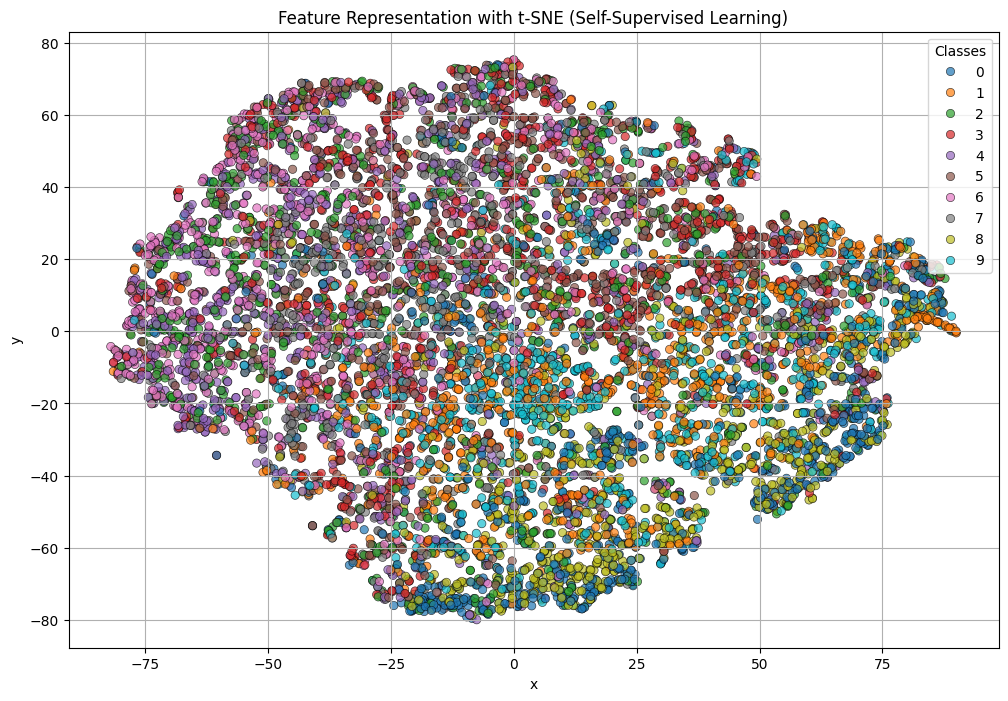

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert t-SNE results to DataFrame
df = pd.DataFrame({"x": tsne_features[:, 0], "y": tsne_features[:, 1], "label": labels})

# Ensure Matplotlib displays output properly
%matplotlib inline

# Plot the t-SNE visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x="x", y="y", hue="label", palette="tab10", alpha=0.7, edgecolor="k")

# Improve visualization
plt.legend(title="Classes", loc="upper right")
plt.title("Feature Representation with t-SNE (Self-Supervised Learning)")
plt.grid(True)
plt.show()

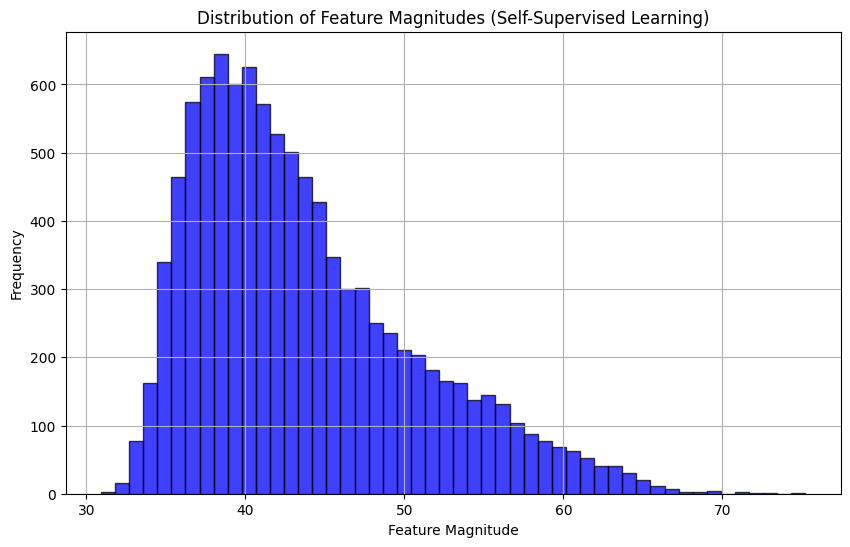

In [14]:
import numpy as np

# Compute feature magnitudes
feature_magnitudes = np.linalg.norm(features, axis=1)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(feature_magnitudes, bins=50, alpha=0.75, color="blue", edgecolor="black")
plt.xlabel("Feature Magnitude")
plt.ylabel("Frequency")
plt.title("Distribution of Feature Magnitudes (Self-Supervised Learning)")
plt.grid(True)
plt.show()
